# **1. Starting Setup**




## 1.1 Download dependencies

In [1]:
!pip install -q "transformers>=4.40.0" datasets accelerate bitsandbytes sentencepiece protobuf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.9 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
import re
from tqdm import tqdm

## 1.2 Setting runtime

In [3]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ No GPU. Go to Runtime → Change runtime type → set GPU.")

CUDA available: False
⚠️ No GPU. Go to Runtime → Change runtime type → set GPU.


## 1.3 Import Dataset

In [4]:
!git clone https://github.com/sooo66/semeval2026-task12-dataset.git
!ls semeval2026-task12-dataset

Cloning into 'semeval2026-task12-dataset'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 27 (delta 7), reused 21 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 6.12 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (7/7), done.
dev_data  README.md  sample_data  test_data  train_data


## 1.4 Constants definition

In [5]:
from pathlib import Path
import json
from typing import Dict, List, Set

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Root of the cloned repo in Colab
DATA_ROOT = Path("/content/semeval2026-task12-dataset")

# Choose the split you want to evaluate: "train_data", "dev_data", or "sample_data"
SPLIT = "dev_data"  # you can change this

QUESTIONS_FILE = DATA_ROOT / SPLIT / "questions.jsonl"
DOCS_FILE      = DATA_ROOT / SPLIT / "docs.json"

print("Questions file:", QUESTIONS_FILE)
print("Docs file:", DOCS_FILE)

Questions file: /content/semeval2026-task12-dataset/dev_data/questions.jsonl
Docs file: /content/semeval2026-task12-dataset/dev_data/docs.json


# **2. Functions to load dataset**

In [6]:
def load_jsonl(path: Path) -> List[Dict]:
    """Read a .jsonl file into a list of dicts."""
    items = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            items.append(json.loads(line))
    return items

def load_json(path: Path):
  """Read a .json file."""
  with path.open("r", encoding="utf-8") as f:
      return json.load(f)

def index_docs_by_topic(docs_list: List[Dict]) -> Dict[int, List[Dict]]:
    """
    Build a mapping: topic_id -> docs (list of dicts).
    Each item in docs_list has: {"topic_id": int, "docs": [ { ... }, ... ] }
    """
    result: Dict[int, List[Dict]] = {}
    for d in docs_list:
        tid = d["topic_id"]
        result[tid] = d["docs"]
    return result

questions = load_jsonl(QUESTIONS_FILE)
docs = load_json(DOCS_FILE)
docs_by_topic = index_docs_by_topic(docs)

print("Num questions:", len(questions))
print("Num doc groups:", len(docs_by_topic))
print("Example question keys:", questions[0].keys())

Num questions: 400
Num doc groups: 36
Example question keys: dict_keys(['topic_id', 'uuid', 'target_event', 'option_A', 'option_B', 'option_C', 'option_D', 'golden_answer'])


# **3. Loading Model**



## 3.1 Import the API key

In [9]:
from google.colab import userdata
from huggingface_hub import login

# 1. Recover the token saved in Colab Secrets (Key icon on the left)
# NOTA: Ensure that the name here below ('HF_TOKEN') is EXACTLY
# the same name cyou gave to the key in the Colab Secrets
token = userdata.get('HF_TOKEN')

# 2. Effettua il login
login(token)

TimeoutException: Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.

## 3.2 Upload the model

In [ ]:
MODEL_NAME = "NousResearch/Hermes-3-Llama-3.1-8B"

# 1. Definition of the quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,              # Active 4-bit loading
    bnb_4bit_quant_type="nf4",      # Use the type "nf4" (more precise)
    bnb_4bit_compute_dtype=torch.float16  # loat16
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

# 2. Loading model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

model.eval()
print("Model loaded on:", model.device)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model loaded on: cuda:0


# **4. Prompt Generation**

## 4.1 Build Context

In [ ]:
def build_context(docs, max_total_chars):
  if not docs:
        context_text = "No context document available"
  else:
        full_context_list = []
        current_length = 0

        for i, doc in enumerate(docs, 1):
            # Take snippet or content
            raw_text = doc.get('content') or doc.get('snippet', '')

            # Clear text to remove useless blank spaces (to reduce waste of resources)
            clean_text = " ".join(raw_text.split())

            # Create the document string
            doc_str = f"--- Document {i} ---\nTitle: {doc.get('title')}\nText: {clean_text}\n\n"

            # Check length: if adding this doc we exceed the limit we don't add it
            if current_length + len(doc_str) > max_total_chars:
                # Add only the part that stays in the limit
                remaining = max_total_chars - current_length
                full_context_list.append(doc_str[:remaining] + "... [TRUNCATED]")
                break
            full_context_list.append(doc_str)
            current_length += len(doc_str)

        context_text = "".join(full_context_list)
  return context_text

In [ ]:
MAX_DOCS_PER_TOPIC = 10
MAX_CHARS_PER_DOC = 1000

def build_context_2(docs):
  text=""
  if not docs:
        text = "No context document available"
  else:
    for i, doc in enumerate(docs[:MAX_DOCS_PER_TOPIC], 1):
        content = doc.get("content", "")
        if len(content) > MAX_CHARS_PER_DOC:
          content = content[:MAX_CHARS_PER_DOC] + "..."

        text += f"Doc {i}:\n"
        text += f"  Title: {doc.get('title', '')}\n"
        text += f"  Snippet: {doc.get('snippet', '')}\n"
        text += f"  Content: {content}\n"
          #text += f"  Link: {doc.get('link', '')}\n"
          #text += f"  Source: {doc.get('source', '')}\n\n"

    return text

In [ ]:
def build_context_3(docs, max_total_chars):
  if not docs:
        context_text = "No context document available"
  else:
        full_context_list = []
        current_length = 0

        for i, doc in enumerate(docs, 1):
            # Take snippet or content
            raw_text = doc.get('snippet') or doc.get('section')

            # Clear text to remove useless blank spaces (to reduce waste of resources)
            clean_text = " ".join(raw_text.split())

            # Create the document string
            doc_str = f"--- Document {i} ---\nTitle: {doc.get('title')}\nText: {clean_text}\n\n"

            # Check length: if adding this doc we exceed the limit we don't add it
            if current_length + len(doc_str) > max_total_chars:
                # Add only the part that stays in the limit
                remaining = max_total_chars - current_length
                full_context_list.append(doc_str[:remaining] + "... [TRUNCATED]")
                break
            full_context_list.append(doc_str)
            current_length += len(doc_str)

        context_text = "".join(full_context_list)
  return context_text

## 4.2 Prompt Structure

In [ ]:
SYSTEM_PROMPT = (
    "You are solving SemEval 2026 Task 12: Abductive Event Reasoning. "
    "Given an event, context documents, and four options (A–D), "
    "choose which option(s) are the most plausible direct cause of the event. "
    "Respond ONLY with the letters of all correct options, "
    "separated by commas (e.g. 'A', 'A,B', or 'D'). "
    "Do not output any explanations."
)

def format_hermes_prompt(question, docs, max_total_chars=6000):
  #1 Obtain the context
  #context_text = build_context(docs,max_total_chars)
  context_text = build_context_2(docs)


  # 2. Prompt Composition
  user_message = f"""{SYSTEM_PROMPT}

Event: "{question['target_event']}"

Context Documents:
{context_text}

Options:
A) {question['option_A']}
B) {question['option_B']}
C) {question['option_C']}
D) {question['option_D']}

Answer (letters only):"""

  messages = [{"role": "user", "content": user_message}]
  prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  return prompt

# **5. Output parsing and scoring function**

In [ ]:
def clean_response(response_text):
    """
    Clean model output to extract only the letters A, B, C, D.
    Handle cases like "Option A", "A.", "A, B", "The answer is C".
    """
    # Remove everything except letters and commas
    # Find for pattern like A, B, C, D
    # Find all uppercase letters A-D in the text
    matches = re.findall(r'\b[A-D]\b', response_text.upper())

    # If does not find anything, return empty string
    if not matches:
        return set()

    # Return set for easy comparision (the order does not count for sets)
    return set(matches)


def calculate_score(prediction_set, golden_string):
    """
    Calculate score: 1.0 (Exact), 0.5 (Partial), 0.0 (Wrong)
    Exact: All letters are correct
    Partial: Some letters are contained in the correct set, but not all
    Wrong: There is a letter not contained in the correct set
    """
    # Clean also the golden answer (that arrives as a string: "C" o "A,B")
    golden_set = set(re.findall(r'\b[A-D]\b', golden_string.upper()))

    if not golden_set:
        print(f"Warning: Golden answer empty or malformed: {golden_string}")
        return 0.0

    # Case 1: Equal (Exact) -> 1 point
    if prediction_set == golden_set:
        return 1.0

    # Case 2: Golden Answer CONTAIN the prediction -> 0.5 points
    # Example: Gold={A, B}, Pred={A} -> Gold contains Pred
    # Esempio: Gold={A}, Pred={A, B} -> Gold DOES NOT contain Pred
    elif prediction_set.issubset(golden_set):
        return 0.5

    # Case 3: Golden does not contain predicted (Wrong) -> 0 punti
    else:
        return 0.0

# **6. Evaluation loop**




## 6.1 Function to compute metrics over the results

In [ ]:
def print_metrics(results):
  perfect_answers = [r for r in results if r['score'] == 1.0]
  partial_answers = [r for r in results if r['score'] == 0.5]

  n_total = len(results)
  n_correct = len(perfect_answers)
  n_partial = len(partial_answers)
  n_wrong = n_total - n_correct - n_partial

  total_score = sum(r['score'] for r in results)

  print(f"======= {MODEL_NAME} Causal Reasoning Results =======")
  print(f"Total questions: {n_total}")
  print(f"Correct answers: {n_correct} - {n_correct/n_total*100}%")
  print(f"Partial answers: {n_partial} - {n_partial/n_total*100}%")
  print(f"Wrong answers: {n_wrong} - {n_wrong/n_total*100}%")
  print(f"Total score: {total_score}")
  print(f"Performance of the score: {total_score/n_total*100}%")


## 6.2 Checkpoints loading

### Mount The Drive and set the Checkpoint path

In [ ]:
import json
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

CHECKPOINT_FILE = "/content/drive/MyDrive/LLM/Hermes/evaluation_checkpoint.jsonl"

Mounted at /content/drive


### Remove previous checkpoints

**CAREFUL: RUN THIS SNIPPET ONLY IF YOU WANT TO START FROM THE BEGINNING**

In [ ]:
## !!! This will delete the checkpoints in your drive !!!
## Commented so that we can use the "Run all previous"

## !rm -rf $CHECKPOINT_FILE

### Load the checkpoints if it exists

In [ ]:
results = []
total_score = 0


processed_uuids = set() # Set to check which question to skip (already processed)

if os.path.exists(CHECKPOINT_FILE):
    print(f"📂 Found checkpoint: {CHECKPOINT_FILE}. Loading checkpoints...")
    with open(CHECKPOINT_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                try:
                    data = json.loads(line)
                    results.append(data)
                    processed_uuids.add(data['uuid']) # Memorize processed ID
                    total_score += data['score']
                except json.JSONDecodeError:
                    continue
    print(f"Restored {len(results)} previous results.")
else:
    print("No checkpoint found. Start a new evaluation")

    # If there is no checkpoints we need to create the path to save it

    folder_path = os.path.dirname(CHECKPOINT_FILE)

    if folder_path:
        os.makedirs(folder_path, exist_ok=True)
        print(f"📁 Created directory: {folder_path}")

No checkpoint found. Start a new evaluation
📁 Created directory: /content/drive/MyDrive/LLM/Gemma


## 6.3 Evaluation Loop

In [ ]:
import gc   # garbage collector

total_score = 0
count = 0
errors = 0

print(f"Starting evaluation on {len(questions)} questions...")


# we use tqdm to see the progress bar
for entry in tqdm(questions):
    question_uuid = entry['uuid']

    # --- SKIP LOGIC ---

    # If UUID is in the processed sed, we skip the iteration
    if question_uuid in processed_uuids:
        continue

    # ------------------

    try:
        topic_id = entry['topic_id']
        question_uuid = entry['uuid']
        golden_ans = entry['golden_answer']

        # Recover documents for this topic
        context_docs = docs_by_topic.get(topic_id, [])

        # 1. Create the prompt
        prompt = format_hermes_prompt(entry, context_docs, max_total_chars=6000)
        if count%10 == 0:
          print(f"[PROMPT DEBUG]:{prompt}")

        # 2. Tokenization
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # 3. Generation (Greedy decoding for reproducibility)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=15,    # Enough for "A, B, C"
                do_sample=False,      # Determinism
                temperature=0.0,
                pad_token_id=tokenizer.eos_token_id
            )

        # 4. Decoding e Cleaning
        # Cutting the input prompt -> the response of the model also contains the input prompt we provided
        generated_ids = outputs[0][inputs.input_ids.shape[1]:]
        raw_response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # Extract the letters set (es. {"A", "B"})
        pred_set = clean_response(raw_response)

        # 5. Calculate score
        score = calculate_score(pred_set, golden_ans)

        # We prepare the result object (a list of result_item, which is the following dictionare)
        result_item = {
            "uuid": question_uuid,
            "topic_id": topic_id,
            "golden_raw": golden_ans,
            "prediction_raw": raw_response,
            "prediction_set": list(pred_set),
            "score": score
        }

        # --- IMMEDIATE SAVING (Checkpoint) ---
        # Append (mode 'a') a new line to the JSONL file
        # Basically, we save in a json (on the drive) every computed answer,
        # so that if something goes wrong we can restore it from the drive
        with open(CHECKPOINT_FILE, 'a', encoding='utf-8') as f:
            f.write(json.dumps(result_item) + "\n")

        # Updating variables in memory
        results.append(result_item)
        processed_uuids.add(question_uuid)
        total_score += score
        count += 1

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"UUID:{entry['uuid']} process skipped due to OOM")
            # forcely free the cache
            del inputs
            torch.cuda.empty_cache()
            gc.collect()
            errors += 1
            continue
        else:
            print(f"Errore generico: {e}")
            continue

Starting evaluation on 400 questions...


  0%|          | 0/400 [00:00<?, ?it/s]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Goldman Sachs estimated that AI systems like ChatGPT could automate up to 300 million jobs worldwide."

Context Documents:
--- Document 1 ---
Title: ‘I felt pure, unconditional love’: the people who marry their AI chatbots
Text: The users of AI companion app Replika found themselves falling for their digital friends. Until – explains a new podcast – the bots went...

--- Document 2 ---
Title: McDonald’s AI Hiring Bot Exposed Millions of Applicants’ Data to Hackers Who Tried the Password ‘123456’
Text: McDonald's AI chatbot Olivia hacked, exposing millions of applicants' data

--- Document 3 ---
Title: AI chatbot's

  9%|▉         | 37/400 [00:25<11:06,  1.84s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Trump was permanently banned from Twitter on January 8th."

Context Documents:
--- Document 1 ---
Title: US Government Designates Riot Games Owner as Chinese Military Company
Text: Learn more about why Tencent, the owner of Riot Games, has been added to US Defense Department's black list.

--- Document 2 ---
Title: Juries aren't swayed by defenses in Capitol riot trials
Text: Webster was the first Jan. 6 defendant to be tried on an assault charge and the first to present a jury with a self-defense argument. His...

--- Document 3 ---
Title: US Department Of Defense Officially Designates 'League Of Legends', 'Path 

 12%|█▏        | 47/400 [00:54<17:16,  2.94s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Global markets plunged following the Brexit vote."

Context Documents:
--- Document 1 ---
Title: What next for EU-Poland ties after Nawrocki's election win?
Text: Newly elected Polish President Karol Nawrocki is known as an EU skeptic. How can he sway Poland's EU policy, and how is he viewed in...

--- Document 2 ---
Title: Pro-Trump candidate wins Poland’s presidential election – a bad omen for the EU, Ukraine and women
Text: Poland's presidential election runoff will be a bitter pill for pro-European Union democrats to swallow. The nationalist, Trumpian...

--- Document 3 ---
Title: Experts react: Conservative K

 14%|█▍        | 57/400 [01:22<16:34,  2.90s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "On January 20, 2025, President Donald Trump sought to delay enforcement of the 2024 law banning TikTok distribution, intending to work out a divestment deal."

Context Documents:
--- Document 1 ---
Title: Town Council votes to ban data centers from Warrenton
Text: Thankfully I have spoken to several Warrenton friends who will NEVER AGAIN vote for Neville. He has to be the most tone deaf mayor ever.

--- Document 2 ---
Title: TikTok | Pros, Cons, Debate, Arguments, Social Media, Internet, China, National Security, Free Speech, & Ban
Text: Should TikTok be banned? Learn the pros and cons of the debate.

--- Document

 17%|█▋        | 67/400 [01:48<14:44,  2.66s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Protesters rallied in Tokyo on August 24, 2023, against the Japanese government’s plan to release treated wastewater from the Fukushima-Daiichi power plant."

Context Documents:
--- Document 1 ---
Title: Unexplained radiation spike found deep in the Pacific ocean
Text: Researchers analyzing deep-sea samples from the Pacific Ocean have discovered an unexplained surge in radiation, one that dates back more than 10 million years.

--- Document 2 ---
Title: Scattering Blanketing Effect Of Earth's Proto-atmosphere: Enhanced Suppression Of Planetary Radiation And Magma Ocean Cooling
Text: The thermal evolution of magma 

 19%|█▉        | 77/400 [02:17<15:02,  2.79s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Nvidia set a new company revenue record."

Context Documents:
--- Document 1 ---
Title: Best Graphics Cards for Gaming in 2025
Text: Since our last look at the best GPUs, both AMD and Nvidia have filled out their current generation product stacks even more,...

--- Document 2 ---
Title: This Artificial Intelligence (AI) Stock Just Hit a New High -- and It's Still a Buy
Text: Nvidia stock has rebounded from its slump earlier this year, hitting a record high on Friday. The company has cornered the data center GPU...

--- Document 3 ---
Title: Best graphics cards in 2025: I've tested pretty much every AMD and Nvidia 

 22%|██▏       | 87/400 [02:46<14:28,  2.77s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "World leaders expressed shock and condemned the murder."

Context Documents:
--- Document 1 ---
Title: Violence Shadows Ecuador's Presidential Election
Text: The drug trade has deepened the security crisis in Ecuador, which will elect a new leader on April 13.

--- Document 2 ---
Title: Should we expect post-election violence?
Text: Election violence is almost guaranteed but it will be localized. We know this script. Self-deployed heavily armed militants will turn up at...

--- Document 3 ---
Title: Clan violence in the Southern Philippines: Rido threatens elections and peace in Bangsamoro
Text: One of the most ci

 24%|██▍       | 97/400 [03:13<14:16,  2.83s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "On December 31, pro-Iranian protesters attacked the US Embassy in Baghdad."

Context Documents:
--- Document 1 ---
Title: Explosive drone downed near Kurdish Peshmerga forces in Iraq's Kirkuk province
Text: The Kurdistan Regional Government's (KRG) Interior Ministry last Friday pointed the finger at Iranian-backed militias in Iraq as the...

--- Document 2 ---
Title: Leveraging Iran’s Defeat to Strengthen U.S.-Iraq Security Relations
Text: Tehran's Iraqi proxies mostly sat out the twelve-day war, but this pragmatic restraint will not forestall growing U.S.-Iran competition over...

--- Document 3 ---
Title: Explos

 27%|██▋       | 107/400 [03:43<14:34,  2.98s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "On August 15, 2021, Afghan President Ashraf Ghani fled the country."

Context Documents:
--- Document 1 ---
Title: Minnesota National Guard unit honored for Afghanistan withdrawal service
Text: Soldiers of the Minnesota National Guard's 1st Combined Arms Battalion – 194th Armor Regiment received three unit awards.

--- Document 2 ---
Title: Trump bashes ‘idiot’ ex-Joint Chiefs Chairman Gen. Mark Milley for leaving weapons behind in Afghanistan
Text: President Donald Trump disclosed he and former Chairman of the Joint Chiefs of Staff Gen. Mark Milley clashed over leaving equipment in...

--- Document 3 ---
Title: T

 29%|██▉       | 117/400 [04:12<13:30,  2.86s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The Pentagon suspended operations against ISIS in Iraq and Syria."

Context Documents:
--- Document 1 ---
Title: Explosive drone downed near Kurdish Peshmerga forces in Iraq's Kirkuk province
Text: The Kurdistan Regional Government's (KRG) Interior Ministry last Friday pointed the finger at Iranian-backed militias in Iraq as the...

--- Document 2 ---
Title: Leveraging Iran’s Defeat to Strengthen U.S.-Iraq Security Relations
Text: Tehran's Iraqi proxies mostly sat out the twelve-day war, but this pragmatic restraint will not forestall growing U.S.-Iran competition over...

--- Document 3 ---
Title: Explosive drone

 32%|███▏      | 127/400 [04:40<13:54,  3.06s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Trump was impeached for a second time on January 13th."

Context Documents:
--- Document 1 ---
Title: US Government Designates Riot Games Owner as Chinese Military Company
Text: Learn more about why Tencent, the owner of Riot Games, has been added to US Defense Department's black list.

--- Document 2 ---
Title: Juries aren't swayed by defenses in Capitol riot trials
Text: Webster was the first Jan. 6 defendant to be tried on an assault charge and the first to present a jury with a self-defense argument. His...

--- Document 3 ---
Title: US Department Of Defense Officially Designates 'League Of Legends', 'Path Of 

 34%|███▍      | 137/400 [05:08<12:05,  2.76s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Huawei’s smartphone sales suffered in international markets."

Context Documents:
--- Document 1 ---
Title: Google Confirms New Hacker Protection For 3 Billion Android Users
Text: New Google update can save your smartphone from hackers — here's how.

--- Document 2 ---
Title: Google just announced 5 new Gemini features coming to Android, and it’s good news for fans of foldable smartphones
Text: Samsung Galaxy Unpacked's many new products and features have not left out AI examples. Plenty involved Google and its Gemini family of AI...

--- Document 3 ---
Title: Jury says Google must pay California Android smartphon

 37%|███▋      | 147/400 [05:36<12:10,  2.89s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Three former Minneapolis police officers were criminally charged with aiding and abetting second-degree murder in connection with Floyd's death, and Chauvin's charge was upgraded to second-degree murder."

Context Documents:
--- Document 1 ---
Title: Skateboards and Livestreams: DHS Tells Police That Common Protest Activities Are ‘Violent Tactics’
Text: DHS is urging law enforcement to treat even skateboarding and livestreaming as signs of violent intent during a protest, turning everyday...

--- Document 2 ---
Title: Kenya's Saba Saba protests: President William Ruto orders police to shoot rioters targeting busin

 39%|███▉      | 157/400 [06:06<11:37,  2.87s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The British pound plunged in value."

Context Documents:
--- Document 1 ---
Title: What next for EU-Poland ties after Nawrocki's election win?
Text: Newly elected Polish President Karol Nawrocki is known as an EU skeptic. How can he sway Poland's EU policy, and how is he viewed in...

--- Document 2 ---
Title: Pro-Trump candidate wins Poland’s presidential election – a bad omen for the EU, Ukraine and women
Text: Poland's presidential election runoff will be a bitter pill for pro-European Union democrats to swallow. The nationalist, Trumpian...

--- Document 3 ---
Title: Experts react: Conservative Karol Nawrocki 

 42%|████▏     | 167/400 [06:35<11:34,  2.98s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Millions of people started using ChatGPT immediately after its launch."

Context Documents:
--- Document 1 ---
Title: ‘I felt pure, unconditional love’: the people who marry their AI chatbots
Text: The users of AI companion app Replika found themselves falling for their digital friends. Until – explains a new podcast – the bots went...

--- Document 2 ---
Title: McDonald’s AI Hiring Bot Exposed Millions of Applicants’ Data to Hackers Who Tried the Password ‘123456’
Text: McDonald's AI chatbot Olivia hacked, exposing millions of applicants' data

--- Document 3 ---
Title: AI chatbot's simple ‘123456’ password riske

 44%|████▍     | 177/400 [07:01<10:07,  2.73s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The Italian government called in the military to enforce its lockdown and ordered non-essential businesses to close by March 22."

Context Documents:
--- Document 1 ---
Title: Seasonal Flu Shots Miss the Mark on Bird Flu Protection
Text: UK researchers find that seasonal flu vaccines don't protect against H5N1 bird flu strains, highlighting the need for targeted vaccines and...

--- Document 2 ---
Title: Trump administration cancels plans to develop a bird flu vaccine
Text: The federal government announced Wednesday that it is canceling a contract to develop a vaccine to protect people against flu viruses that...


 47%|████▋     | 187/400 [07:29<10:09,  2.86s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "President Yoon Suk-yeol declared a period of national mourning and designated Itaewon a disaster zone."

Context Documents:
--- Document 1 ---
Title: Zootown Festival draws crowds and cash to Missoula
Text: Missoula's largest music festival in decades brought in big bucks for the county over Independence Day weekend. County officials say the...

--- Document 2 ---
Title: Crowd Goes Wild as 'Blues Brothers' Jim Belushi and Dan Aykroyd Hit the Stage for Surprise Performance at Country Music Festival: 'Legendary'
Text: Crowd Goes Wild as 'Blues Brothers' Jim Belushi and Dan Aykroyd Hit the Stage for Surprise Performa

 49%|████▉     | 197/400 [07:57<09:53,  2.92s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Bushfire smoke created smog in Sydney, causing air quality to reach 22 times worse than standard levels and causing respiratory problems for residents."

Context Documents:
--- Document 1 ---
Title: Is the insurance industry ready for the climate crisis?
Text: As climate change continues to escalate, its ripple effects are being felt across every corner of the built environment, none more so than...

--- Document 2 ---
Title: How does climate change cause wildfires? | IFAW
Text: Research shows a clear link between climate change and larger, more destructive wildfires. To reduce the number and the severity of devas

 52%|█████▏    | 207/400 [08:28<09:47,  3.04s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Local governments established public mourning sites."

Context Documents:
--- Document 1 ---
Title: Zootown Festival draws crowds and cash to Missoula
Text: Missoula's largest music festival in decades brought in big bucks for the county over Independence Day weekend. County officials say the...

--- Document 2 ---
Title: Crowd Goes Wild as 'Blues Brothers' Jim Belushi and Dan Aykroyd Hit the Stage for Surprise Performance at Country Music Festival: 'Legendary'
Text: Crowd Goes Wild as 'Blues Brothers' Jim Belushi and Dan Aykroyd Hit the Stage for Surprise Performance at Country Music Festival:...

--- Document 3 

 54%|█████▍    | 217/400 [08:55<08:00,  2.63s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Officials confirmed on Monday that the death toll rose to 154 and 149 people were injured."

Context Documents:
--- Document 1 ---
Title: Zootown Festival draws crowds and cash to Missoula
Text: Missoula's largest music festival in decades brought in big bucks for the county over Independence Day weekend. County officials say the...

--- Document 2 ---
Title: Crowd Goes Wild as 'Blues Brothers' Jim Belushi and Dan Aykroyd Hit the Stage for Surprise Performance at Country Music Festival: 'Legendary'
Text: Crowd Goes Wild as 'Blues Brothers' Jim Belushi and Dan Aykroyd Hit the Stage for Surprise Performance at Count

 57%|█████▋    | 227/400 [09:24<07:52,  2.73s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Derek Chauvin was arrested and charged with murder and manslaughter."

Context Documents:
--- Document 1 ---
Title: Skateboards and Livestreams: DHS Tells Police That Common Protest Activities Are ‘Violent Tactics’
Text: DHS is urging law enforcement to treat even skateboarding and livestreaming as signs of violent intent during a protest, turning everyday...

--- Document 2 ---
Title: Kenya's Saba Saba protests: President William Ruto orders police to shoot rioters targeting businesses in the legs
Text: Kenya's President William Ruto has ordered police to shoot protesters targeting businesses in the legs, ensurin

 59%|█████▉    | 237/400 [09:52<07:23,  2.72s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Up to six ERCOT board members resigned on February 24."

Context Documents:
--- Document 1 ---
Title: Listed here: Safety tips from National Grid to get snow, ice off your home
Text: National Grid is offering safety tips for clearing snow from your home or business. The power company's tips come after large sections of Central New York saw...

--- Document 2 ---
Title: Off-grid homeowner busts popular myth about the usefulness of solar panels — here's what people are getting wrong
Text: It turns out solar panels can generate power even when they're covered in snow. Off-grid rancher Jason (@HanbleceyaRanch) showed 

 62%|██████▏   | 247/400 [10:21<07:16,  2.85s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Amazonas state in Brazil declared a state of emergency due to the fires."

Context Documents:
--- Document 1 ---
Title: How Does Deforestation Affect the Environment?
Text: This practice threatens our environment, from altering the climate and various ecosystems to compromising the existence of millions of humans and animals.

--- Document 2 ---
Title: Deforestation: causes and how the EU is tackling it
Text: Find out what causes deforestation and how new EU legislation is set to limit the importation of goods produced on deforested land.

--- Document 3 ---
Title: Guidelines and Recommendations for Halting Defore

 64%|██████▍   | 257/400 [10:51<07:26,  3.12s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The country's currency plummeted in value and government borrowing costs rose after the announcement."

Context Documents:
--- Document 1 ---
Title: Chomps Launches Pound-for-Pound Plastic Removal Effort with 4ocean
Text: Meat snack brand Chomps has launched a new partnership with global cleanup organization 4ocean, establishing a pound-for-pound plastic removal commitment.

--- Document 2 ---
Title: Pumpkin grown in Leader reaches over 1000 lbs
Text: Pumpkin grown in Leader reaches over 1000 lbs · Gary Wenzel of Leader, Sask. stands near the 1080 pound pumpkin he grew this year. Ross Lavigne/...

--- Document 3 -

 67%|██████▋   | 267/400 [11:18<06:00,  2.71s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The US Senate will likely vote on Wednesday on a bill to halt Trump’s tariffs on Canadian imports."

Context Documents:
--- Document 1 ---
Title: Mexico | US tariff adjustments: less trade protectionism with Mexico
Text: Key points ... The tariffs will now not be cumulative. Therefore, Mexico will no longer face 50% tariffs, and those affected by tariffs of this...

--- Document 2 ---
Title: 'Protectionism harms all, is ultimately unpopular,' says China on court blocking Trump tariffs
Text: US tariffs 'has not only failed to solve any of its own problems, but has also seriously undermined the international economi

 69%|██████▉   | 277/400 [11:48<06:11,  3.02s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Shinzo Abe was pronounced dead at 5:03 p.m."

Context Documents:
--- Document 1 ---
Title: Violence Shadows Ecuador's Presidential Election
Text: The drug trade has deepened the security crisis in Ecuador, which will elect a new leader on April 13.

--- Document 2 ---
Title: Should we expect post-election violence?
Text: Election violence is almost guaranteed but it will be localized. We know this script. Self-deployed heavily armed militants will turn up at...

--- Document 3 ---
Title: Clan violence in the Southern Philippines: Rido threatens elections and peace in Bangsamoro
Text: One of the most cited reasons 

 72%|███████▏  | 287/400 [12:17<05:28,  2.90s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "President Joe Biden approved a major disaster declaration for Texas."

Context Documents:
--- Document 1 ---
Title: Listed here: Safety tips from National Grid to get snow, ice off your home
Text: National Grid is offering safety tips for clearing snow from your home or business. The power company's tips come after large sections of Central New York saw...

--- Document 2 ---
Title: Off-grid homeowner busts popular myth about the usefulness of solar panels — here's what people are getting wrong
Text: It turns out solar panels can generate power even when they're covered in snow. Off-grid rancher Jason (@Hanbleceya

 74%|███████▍  | 297/400 [12:45<04:55,  2.87s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "TEPCO began releasing the first batch of treated radioactive water into the Pacific Ocean."

Context Documents:
--- Document 1 ---
Title: Unexplained radiation spike found deep in the Pacific ocean
Text: Researchers analyzing deep-sea samples from the Pacific Ocean have discovered an unexplained surge in radiation, one that dates back more than 10 million years.

--- Document 2 ---
Title: Scattering Blanketing Effect Of Earth's Proto-atmosphere: Enhanced Suppression Of Planetary Radiation And Magma Ocean Cooling
Text: The thermal evolution of magma oceans formed by giant impacts is strongly influenced by a proto-a

 77%|███████▋  | 307/400 [13:11<04:12,  2.72s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The Swiss government ordered Credit Suisse to temporarily suspend bonus payments to staff."

Context Documents:
--- Document 1 ---
Title: Distress signals: Cooperation agreements or mergers to the rescue in times of crisis? | Türkiye | Global law firm
Text: This article provides a brief overview of merger control considerations when acquiring distressed assets, focusing on the standards applicable in the European...

--- Document 2 ---
Title: Crises, Stakeholders and Merger Success
Text: Merging with rival firms can reduce competition, lower operational costs and expand existing markets, allowing companies to grow

 79%|███████▉  | 317/400 [13:39<03:52,  2.80s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The city fires all four officers."

Context Documents:
--- Document 1 ---
Title: Skateboards and Livestreams: DHS Tells Police That Common Protest Activities Are ‘Violent Tactics’
Text: DHS is urging law enforcement to treat even skateboarding and livestreaming as signs of violent intent during a protest, turning everyday...

--- Document 2 ---
Title: Kenya's Saba Saba protests: President William Ruto orders police to shoot rioters targeting businesses in the legs
Text: Kenya's President William Ruto has ordered police to shoot protesters targeting businesses in the legs, ensuring they are incapacitated but...

--

 82%|████████▏ | 327/400 [14:09<03:43,  3.06s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "India sent approximately 15 tonnes of relief material to Myanmar via an IAF C-130J aircraft."

Context Documents:
--- Document 1 ---
Title: Flash flood vulnerability should be reduced
Text: FLOODING from incessant rain caused by the recent depression in the Bay of Bengal has remained somewhat unchanged while the government's...

--- Document 2 ---
Title: Switzerland: Flood risk after landslide engulfs village
Text: Authorities are using a drone with a thermal camera to search for a 64-year-old man missing after a massive landslide.

--- Document 3 ---
Title: At least 30 killed in India’s northeast as rains trigger

 84%|████████▍ | 337/400 [14:37<02:57,  2.82s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "The last U.S. military planes departed Afghanistan around midnight Monday (Kabul time), completing the withdrawal."

Context Documents:
--- Document 1 ---
Title: Minnesota National Guard unit honored for Afghanistan withdrawal service
Text: Soldiers of the Minnesota National Guard's 1st Combined Arms Battalion – 194th Armor Regiment received three unit awards.

--- Document 2 ---
Title: Trump bashes ‘idiot’ ex-Joint Chiefs Chairman Gen. Mark Milley for leaving weapons behind in Afghanistan
Text: President Donald Trump disclosed he and former Chairman of the Joint Chiefs of Staff Gen. Mark Milley clashed over leavi

 87%|████████▋ | 347/400 [15:07<02:55,  3.31s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Facebook changed its corporate name to Meta on October 28 at the company's annual Connect event."

Context Documents:
--- Document 1 ---
Title: Enhancing social functioning using multi-user, immersive virtual reality
Text: To our knowledge, this is the first multi-user VR application tested for this purpose. Preliminary evidence was also found for beneficial...

--- Document 2 ---
Title: Social-media app WeAre8 is holding a virtual music festival
Text: WeAre8 is a social-media app whose USP (it hopes) is that it's a more positive environment than its established rivals.

--- Document 3 ---
Title: CITRIS Tech for S

 89%|████████▉ | 357/400 [15:36<02:02,  2.85s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Musk laid off thousands of Twitter employees and contractors."

Context Documents:
--- Document 1 ---
Title: Publicis Groupe Taps Captiv8 to Power AI-Driven Social Commerce
Text: Publicis's acquisition of Captiv8 transforms influencer marketing with AI-driven tools, full-funnel solutions, and integrated social...

--- Document 2 ---
Title: MaskDAO Expands Web3 Footprint with Orb.club Acquisition
Text: In a strategic move to reinforce its presence in the decentralized social networking landscape, MaskDAO has completed the acquisition of...

--- Document 3 ---
Title: Triple Point Social Housing REIT Share Acquisitio

 92%|█████████▏| 367/400 [16:01<01:17,  2.35s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Prime Minister Hassan Diab and his government resigned following the explosion."

Context Documents:
--- Document 1 ---
Title: Explosion at pharmaceutical factory in southern India kills at least 40
Text: The death toll is expected to rise as authorities search the rubble of a Sigachi Industries plant in the Indian state of Telangana.

--- Document 2 ---
Title: At least 39 killed in fire at Indian pharmaceutical factory
Text: The death toll from the explosion and fire at Sigachi Industries' SIGC.NS chemical factory in southern India has risen to at least 39,...

--- Document 3 ---
Title: India: Death toll in Sigac

 94%|█████████▍| 377/400 [16:29<01:09,  3.00s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Wagner troops withdrew from Rostov, the Lipetsk region, and Moscow."

Context Documents:
--- Document 1 ---
Title: Will Putin be toppled by a military coup?
Text: In Putin's Sledgehammer, Candace Rondeaux gives a detailed account of the 2023 mutiny led by Yevgeny Prigozhin. Could rising discontent in...

--- Document 2 ---
Title: Civil war in russia: a military coup or a decree from Prigozhin?
Text: The American Institute for the Study of War also confirms the inevitable impact of Prigozhin's rebellion against the russian Defense Ministry on the war in...

--- Document 3 ---
Title: Wagner chief's 24 hours of chaos

 97%|█████████▋| 387/400 [16:59<00:38,  2.96s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Thousands of volunteers from Lebanon and its diaspora cleared rubble, offered accommodation, and repaired homes in affected areas after the explosion."

Context Documents:
--- Document 1 ---
Title: Explosion at pharmaceutical factory in southern India kills at least 40
Text: The death toll is expected to rise as authorities search the rubble of a Sigachi Industries plant in the Indian state of Telangana.

--- Document 2 ---
Title: At least 39 killed in fire at Indian pharmaceutical factory
Text: The death toll from the explosion and fire at Sigachi Industries' SIGC.NS chemical factory in southern India has risen t

 99%|█████████▉| 397/400 [17:28<00:08,  2.90s/it]

[PROMPT DEBUG]:<bos><start_of_turn>user
You are solving SemEval 2026 Task 12: Abductive Event Reasoning. Given an event, context documents, and four options (A–D), choose which option(s) are the most plausible direct cause of the event. Respond ONLY with the letters of all correct options, separated by commas (e.g. 'A', 'A,B', or 'D'). Do not output any explanations.

Event: "Iran announced it would suspend compliance with the 2015 nuclear deal while continuing to work with IAEA inspectors."

Context Documents:
--- Document 1 ---
Title: Explosive drone downed near Kurdish Peshmerga forces in Iraq's Kirkuk province
Text: The Kurdistan Regional Government's (KRG) Interior Ministry last Friday pointed the finger at Iranian-backed militias in Iraq as the...

--- Document 2 ---
Title: Leveraging Iran’s Defeat to Strengthen U.S.-Iraq Security Relations
Text: Tehran's Iraqi proxies mostly sat out the twelve-day war, but this pragmatic restraint will not forestall growing U.S.-Iran competition

100%|██████████| 400/400 [17:37<00:00,  2.64s/it]


{'topic_id': 15, 'uuid': '96886b87-d214-49e5-91cd-0ba4256039fe', 'target_event': 'Goldman Sachs estimated that AI systems like ChatGPT could automate up to 300 million jobs worldwide.', 'option_A': 'OpenAI released ChatGPT Plus on February 1, 2023, and later introduced GPT-4 Turbo with Vision and GPT-4o to the public.', 'option_B': 'Stack Overflow banned ChatGPT-generated answers due to their misleading incorrectness.', 'option_C': 'None of the others are correct causes.', 'option_D': 'OpenAI launched the DALL-E 2 beta on July 20, 2022.', 'golden_answer': 'C'}

{'title': '‘I felt pure, unconditional love’: the people who marry their AI chatbots', 'link': 'https://www.theguardian.com/tv-and-radio/2025/jul/12/i-felt-pure-unconditional-love-the-people-who-marry-their-ai-chatbots', 'snippet': 'The users of AI companion app Replika found themselves falling for their digital friends. Until – explains a new podcast – the bots went...', 'source': 'The Guardian', 'imageUrl': '', 'content': 'A l
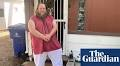
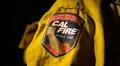
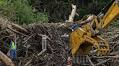
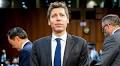
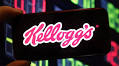
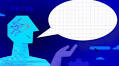
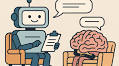
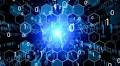
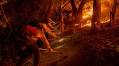
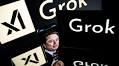
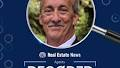
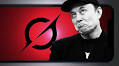
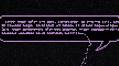
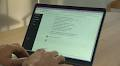
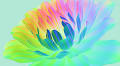
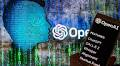
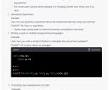
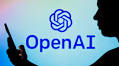
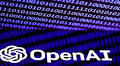
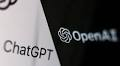
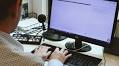
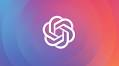
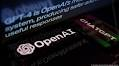
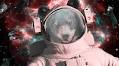
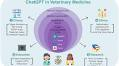

In [ ]:
print(questions[27])
docs= docs_by_topic.get(15)
for doc in docs:
  print()
  print(doc)

# **7. Results**

In [ ]:
# Final Report -- Printing Correct, Partial, Wrong answers and the score

print_metrics(results)

======= google/gemma-2-9b-it Causal Reasoning Results =======
Total questions: 400
Correct answers: 170 - 42.5%
Partial answers: 40 - 10.0%
Wrong answers: 190 - 47.5%
Total score: 190.0
Performance of the score: 47.5%
